In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy import stats
from collections import Counter
from datasets import load_dataset
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")


def analyze_csv(file_path_a, file_path_b, kmer=1, p_value_threshold=1e-5, dataset_type='test', population_freq=None, k=1):
    df_a = pd.read_csv(file_path_a)
    df_b = pd.read_csv(file_path_b)

    # Separate Real and Random data for both datasets
    df_a_real = df_a[(df_a['Random'] == False) & (df_a['sectional'] == False) & (df_a['k'] == k)]
    df_a_random = df_a[df_a['Random'] == True]
    df_b_real = df_b[(df_b['Random'] == False) & (df_b['sectional'] == False) & (df_a['k'] == k)]
    df_b_random = df_b[df_b['Random'] == True]
    
    # Create filtered datasets for each percentage
    percentages = [0.05, 0.15, 0.30, 0.50, 0.70, 1.0]
    df_a_real_filtered = pd.DataFrame()
    df_b_real_filtered = pd.DataFrame()
    
    for percent in percentages:
        df_a_percent = df_a_real[df_a_real['percentage'] == percent]
        df_b_percent = df_b_real[df_b_real['percentage'] == percent]
        
        df_a_filtered = filter_sequences(df_a_percent, kmer, p_value_threshold, population_freq=population_freq)
        df_b_filtered = filter_sequences(df_b_percent, kmer, p_value_threshold, population_freq=population_freq)
        
        df_a_real_filtered = pd.concat([df_a_real_filtered, df_a_filtered])
        df_b_real_filtered = pd.concat([df_b_real_filtered, df_b_filtered])
    
    # Assign 'Model' values
    df_a_real['Model'] = f'GSM_{dataset_type}_unfiltered'
    df_b_real['Model'] = f'ESM2-150_{dataset_type}_unfiltered'
    df_a_real_filtered['Model'] = f'GSM_{dataset_type}_filtered'
    df_b_real_filtered['Model'] = f'ESM2-150_{dataset_type}_filtered'
    
    # Combine random baselines
    df_random_combined = pd.concat([df_a_random, df_b_random])
    df_random_combined['Model'] = f'Random_{dataset_type}'
    
    # Combine all datasets
    plot_data = pd.concat([df_a_real, df_b_real, df_a_real_filtered, df_b_real_filtered, df_random_combined])
    
    for percent in percentages:
        print(f"\nPercentage: {percent}")
        print(f"Unfiltered GSM: {len(df_a_real[df_a_real['percentage'] == percent])}, "
              f"Unfiltered ESM2-150: {len(df_b_real[df_b_real['percentage'] == percent])}")
        print(f"Filtered GSM: {len(df_a_real_filtered[df_a_real_filtered['percentage'] == percent])}, "
              f"Filtered ESM2-150: {len(df_b_real_filtered[df_b_real_filtered['percentage'] == percent])}")
        print(f"Random: {len(df_random_combined[df_random_combined['percentage'] == percent])}")
    
    return plot_data

def filter_sequences(df, kmer=1, p_value_threshold=1e-5, population_freq=None):
    query_seqs = df['generated_seq'].tolist()
    results, removed, kept = remove_bad_generations(query_seqs, kmer, p_value_threshold, population_freq)
    # Create a mask for kept sequences
    kept_mask = df['generated_seq'].isin(kept)
    return df[kept_mask]

def calculate_kmer_frequencies(sequence, k):
    """Calculate k-mer frequencies in a sequence."""
    if k == 1:
        return Counter(sequence)
    else:
        return Counter(sequence[i:i+k] for i in range(len(sequence)-k+1))

def chi_squared_test(query_freq, population_freq):
    """Perform chi-squared test between query and population frequencies."""
    all_kmers = set(query_freq.keys()) | set(population_freq.keys())
    observed = np.array([query_freq.get(kmer, 0) for kmer in all_kmers])
    expected = np.array([population_freq.get(kmer, 0) for kmer in all_kmers])
    # Normalize expected frequencies
    total_population = sum(population_freq.values())
    total_query = sum(query_freq.values())
    expected = expected / total_population * total_query
    # Remove zeros to avoid division by zero in chi-squared calculation
    mask = expected != 0
    observed = observed[mask]
    expected = expected[mask]
    chi2, p_value = stats.chisquare(observed, expected)
    return chi2, p_value


def remove_bad_generations(query_seqs, k, p_value_threshold, population_freq):
    results, removed, kept = [], [], []
    for q in tqdm(query_seqs):
        query_freq = calculate_kmer_frequencies(q, k)
        chi2, p_value = chi_squared_test(query_freq, population_freq)
        results.append((q, chi2, p_value))
        if p_value < p_value_threshold:
            removed.append(q)
        else:
            kept.append(q)
    results.sort(key=lambda x: x[2])
    return results, removed, kept

In [2]:
training_data_path = 'GleghornLab/AnnotationVocab'
training_data = load_dataset(training_data_path)
total_seqs = []
for k, dataset in training_data.items():
    total_seqs.extend(dataset['seqs'])

total_seqs = list(set(total_seqs))
population_freq = Counter()
for seq in total_seqs:
    population_freq.update(calculate_kmer_frequencies(seq, 1))

Using the latest cached version of the dataset since GleghornLab/AnnotationVocab couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\Logan\.cache\huggingface\datasets\GleghornLab___annotation_vocab\default\0.0.0\d08bb981a12b22ba1b342dbedaf06d4ba31eb3b6 (last modified on Sun Jul 21 23:42:24 2024).


In [21]:
thresh = 1e-20
test_data = analyze_csv('GSM_test.csv',
                        'ESM_test.csv',
                        1, p_value_threshold=thresh,
                        dataset_type='test',
                        population_freq=population_freq,
                        k=1)

train_data = analyze_csv('GSM_train.csv',
                         'ESM_train.csv',
                         1, p_value_threshold=thresh,
                         dataset_type='train',
                         population_freq=population_freq,
                         k=1)

train, test = False, True

combined_data = []
if train:
    combined_data.append(train_data)
if test:
    combined_data.append(test_data)

combined_data = pd.concat(combined_data)

100%|██████████| 1000/1000 [00:00<00:00, 6480.34it/s]



Percentage: 0.05
Unfiltered GSM: 1000, Unfiltered ESM2-150: 1000
Filtered GSM: 992, Filtered ESM2-150: 993
Random: 2000

Percentage: 0.15
Unfiltered GSM: 1000, Unfiltered ESM2-150: 1000
Filtered GSM: 967, Filtered ESM2-150: 986
Random: 2000

Percentage: 0.3
Unfiltered GSM: 1000, Unfiltered ESM2-150: 1000
Filtered GSM: 841, Filtered ESM2-150: 954
Random: 4000

Percentage: 0.5
Unfiltered GSM: 1000, Unfiltered ESM2-150: 1000
Filtered GSM: 637, Filtered ESM2-150: 688
Random: 2000

Percentage: 0.7
Unfiltered GSM: 1000, Unfiltered ESM2-150: 1000
Filtered GSM: 396, Filtered ESM2-150: 1
Random: 2000

Percentage: 1.0
Unfiltered GSM: 1000, Unfiltered ESM2-150: 1000
Filtered GSM: 47, Filtered ESM2-150: 0
Random: 2000


100%|██████████| 1000/1000 [00:00<00:00, 6990.17it/s]



Percentage: 0.05
Unfiltered GSM: 1000, Unfiltered ESM2-150: 1000
Filtered GSM: 973, Filtered ESM2-150: 974
Random: 2000

Percentage: 0.15
Unfiltered GSM: 1000, Unfiltered ESM2-150: 1000
Filtered GSM: 950, Filtered ESM2-150: 961
Random: 2000

Percentage: 0.3
Unfiltered GSM: 1000, Unfiltered ESM2-150: 1000
Filtered GSM: 844, Filtered ESM2-150: 906
Random: 4000

Percentage: 0.5
Unfiltered GSM: 1000, Unfiltered ESM2-150: 1000
Filtered GSM: 680, Filtered ESM2-150: 550
Random: 2000

Percentage: 0.7
Unfiltered GSM: 1000, Unfiltered ESM2-150: 1000
Filtered GSM: 465, Filtered ESM2-150: 1
Random: 2000

Percentage: 1.0
Unfiltered GSM: 1000, Unfiltered ESM2-150: 1000
Filtered GSM: 133, Filtered ESM2-150: 0
Random: 2000


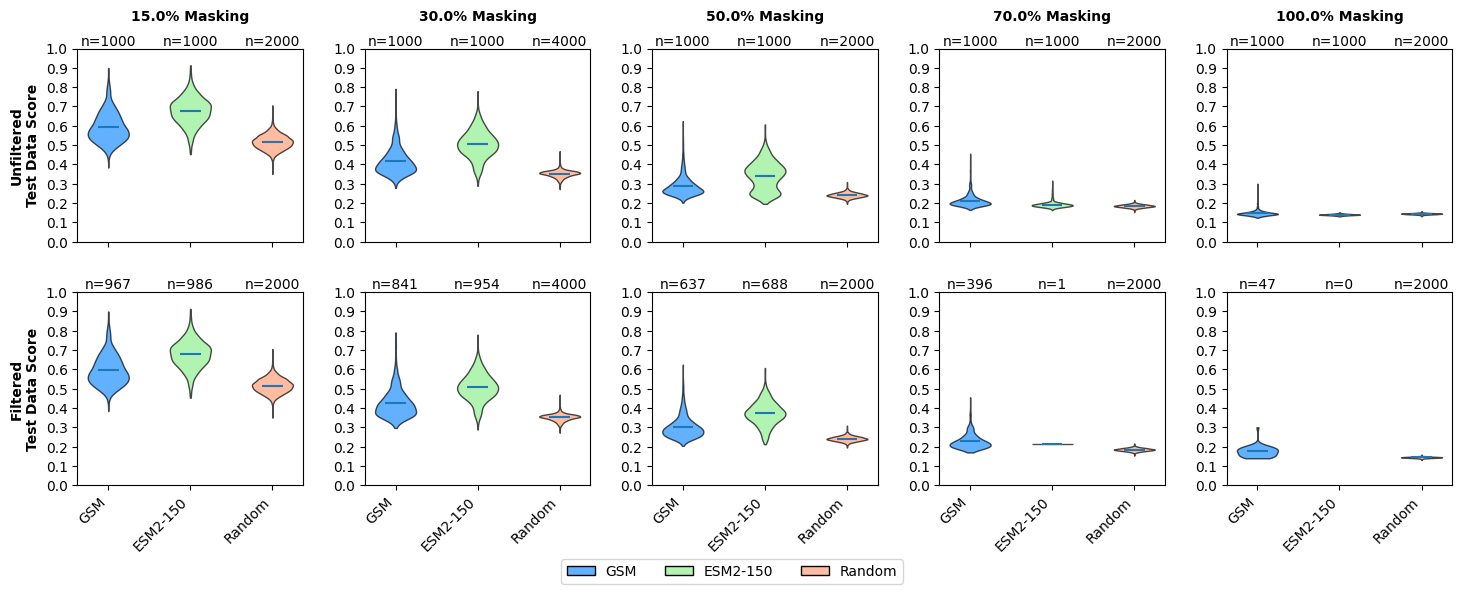

In [42]:


def create_combined_violin_plots(plot_data, train=True, test=True):
    percentages = [0.15, 0.30, 0.50, 0.70, 1.0]
    height = 2 * (train + test)
    width = len(percentages)
    fig, axes = plt.subplots(height, width, figsize=(width * 3, height * 3))
    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    
    categories = []
    if train:
        categories.append(('train', 'unfiltered'))
        categories.append(('train', 'filtered'))
    if test:
        categories.append(('test', 'unfiltered'))
        categories.append(('test', 'filtered'))

    # Find global min and max scores
    all_scores = plot_data['score']
    global_min = np.floor(0 * 10) / 10  # Round down to nearest 0.1
    global_max = np.ceil(1 * 10) / 10   # Round up to nearest 0.1
    
    # Define soft colors for each model
    colors = {
        'GSM': mcolors.to_rgba('#1E90FF', alpha=0.7),  # Soft blue
        'ESM2-150': mcolors.to_rgba('#90EE90', alpha=0.7),  # Soft green
        'Random': mcolors.to_rgba('#FFA07A', alpha=0.7)  # Soft salmon
    }
    
    for i, (dataset, filter_status) in enumerate(categories):
        for j, percentage in enumerate(percentages):
            ax = axes[i, j]
            data_gsm = plot_data[(plot_data['percentage'] == percentage) & 
                                    (plot_data['Model'] == f'GSM_{dataset}_{filter_status}')]
            data_esm = plot_data[(plot_data['percentage'] == percentage) & 
                                    (plot_data['Model'] == f'ESM2-150_{dataset}_{filter_status}')]
            data_random = plot_data[(plot_data['percentage'] == percentage) & 
                                    (plot_data['Model'] == f'Random_{dataset}')]
            
            scores_gsm = data_gsm['score'].tolist() if not data_gsm.empty else []
            scores_esm = data_esm['score'].tolist() if not data_esm.empty else []
            scores_random = data_random['score'].tolist() if not data_random.empty else []

            data_to_plot = [scores_gsm, scores_esm, scores_random]
            labels = ['GSM', 'ESM2-150', 'Random']

            positions = range(len(labels))
            parts = ax.violinplot([d for d in data_to_plot if d], 
                                    positions=[p for p, d in enumerate(data_to_plot) if d], 
                                    showmeans=True, 
                                    showextrema=False, 
                                    showmedians=False)
            
            for pc, label in zip(parts['bodies'], [l for l, d in zip(labels, data_to_plot) if d]):
                pc.set_facecolor(colors[label])
                pc.set_edgecolor('black')
                pc.set_alpha(0.7)
            
            ax.set_xticks(positions)
            
            # Set consistent y-axis limits and ticks
            ax.set_ylim(global_min, global_max)
            ax.set_yticks(np.arange(global_min, global_max + 0.1, 0.1))
            ax.set_yticklabels([f'{x:.1f}' for x in np.arange(global_min, global_max + 0.1, 0.1)])
            
            # Add sample size (n) to each violin plot, including n=0 for empty data
            for idx, scores in enumerate(data_to_plot):
                ax.text(idx, ax.get_ylim()[1], f'n={len(scores)}',
                        horizontalalignment='center', verticalalignment='bottom', fontsize=10)
            
            # Set the title after adding the sample size text
            if i == 0:
                ax.set_title(f'{percentage*100}% Masking', fontsize=10, pad=20, fontweight='bold')
            
            if j == 0:
                ax.set_ylabel(f'{filter_status}\n{dataset.capitalize()} data score'.title(), fontsize=10, fontweight='bold')
            else:
                ax.set_ylabel('')
            
            # Set x-axis tick labels only for the bottom row, but keep consistent labeling
            if i == height - 1:
                ax.set_xticklabels(labels, rotation=45, ha='right')
            else:
                ax.set_xticklabels([])
            
    # Add a legend
    handles = [plt.Rectangle((0,0),1,1, facecolor=colors[label], edgecolor='black') for label in labels]
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)
    
    # Use tight_layout with some padding
    plt.tight_layout(pad=2.0)
    plt.savefig('combined_violin_plots.png', dpi=300, bbox_inches='tight')

# Create combined plots
create_combined_violin_plots(combined_data, train=train, test=test)